### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
* If you haven't done seminar already, use `seminar.ipynb` to download the data.
* This homework uses Pytorch v1.x: this is [how you install it](https://pytorch.org/get-started/locally/); and that's [how you use it](https://github.com/yandexdataschool/Practical_RL/tree/9f89e98d7df7ad47f5d6c85a70a38283e06be16a/week04_%5Brecap%5D_deep_learning).

In [97]:
# Alternative manual download link: https://yadi.sk/d/_nGyU2IajjR9-w
!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz

--2023-12-03 19:49:15--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz [following]
--2023-12-03 19:49:16--  https://www.dropbox.com/s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6da04d5c9a9720ebfd625c6f7e.dl.dropboxusercontent.com/cd/0/get/CIsPB3aWOdF_KVWJBFbmntuFSK6X7xpzMz6UfD8aPLVzQHZBS5tiXUOYfS-ANxJHaiQ6XXEaEi9TYErEg7IdZp7KLv8JU894Tsa4PbnW5pG57OupoKIS1MYrEbBwyZBK6G8/file?dl=1# [following]
--2023-12-03 19:49:16--  https://uc6da04d5c9a9720ebfd625c6f7e.dl.dropboxusercontent.com/cd/0/get/CIsPB3aWOdF_KVWJBFbmntuFSK6X7xpzMz6UfD8aPLVzQHZBS5tiXUOYfS-ANxJHaiQ6XXEaEi9TYErEg7IdZp7KLv8

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [99]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [100]:
# get all unique characters from lines (including capital letters and symbols)
tokens = set("".join(lines))

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with it's index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [101]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [102]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integet matrix `[batch_size, text_length]`.

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra _EOS_ or cropping long sequences. Here's how it works:

In [103]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [104]:
#Example: cast 4 random names to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))



[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model (2 points including training)

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [106]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [107]:
from dataclasses import dataclass


activations = {
    "prelu": nn.PReLU(),
    "relu": nn.ReLU(inplace=True),
    None: nn.Identity()
}


@dataclass
class FixedWindowLMConfig:
    emb_size: int = 16
    kernel_size: int = 5
    stride: int = 1
    n_layers_in_block = 3
    n_blocks = 2
    hidden_size: int = 64
    activation: str = "prelu"


class LMConv1d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, activation=nn.ReLU(inplace=True)):
        super().__init__()
        self.pad = nn.ZeroPad2d(((kernel_size - 1) * stride, 0, 0, 0))
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=0)
        self.activation = activation or nn.Identity()

    def forward(self, x):
        x = self.pad(x)
        x = self.conv(x)
        x = self.activation(x)
        return x


class LMConvBlock(nn.Module):

    def __init__(self, hidden_size, kernel_size, stride, n_layers=3, activation=nn.ReLU(inplace=True)):
        super().__init__()
        self.convs = nn.ModuleList([
            LMConv1d(hidden_size, hidden_size, kernel_size, stride, activation=nn.ReLU(inplace=True))
            for _ in range(n_layers)
        ])

    def forward(self, x):
        for conv in self.convs:
            x = conv(x) + x
        return x


class FixedWindowLanguageModel(nn.Module):
    def __init__(self, cfg, n_tokens=n_tokens):
        """
        A fixed window model that looks on at least 5 previous symbols.

        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}

        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        self.cfg = cfg
        self.n_tokens = n_tokens

        self.embedding = nn.Embedding(self.n_tokens, cfg.emb_size, padding_idx=token_to_id[EOS])
        activation = activations[cfg.activation]
        self.conv_start = LMConv1d(
            cfg.emb_size,
            cfg.hidden_size,
            cfg.kernel_size,
            cfg.stride,
            activation=activation,
        )
        if cfg.n_layers_in_block > 0:
            self.conv_blocks = []
            for idx in range(cfg.n_blocks):
                self.conv_blocks.append(
                    LMConvBlock(
                        cfg.hidden_size,
                        cfg.kernel_size,
                        cfg.stride,
                        n_layers=cfg.n_layers_in_block,
                        activation=activation,
                    )
                )
            self.conv_blocks = nn.Sequential(*self.conv_blocks)
        else:
            self.conv_blocks = nn.Identity()
        self.classifier = nn.Linear(cfg.hidden_size, self.n_tokens)

    def forward(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})

        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        x = self.embedding(input_ix)
        x = torch.permute(x, (0, 2, 1))
        x = self.conv_start(x)
        x = self.conv_blocks(x)
        x = torch.permute(x, (0, 2, 1))
        x = self.classifier(x)
        return x # output tensor should be of shape [batch_size, sequence_length, n_tokens]

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64, device=device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))


In [108]:
cfg = FixedWindowLMConfig()
dummy_model = FixedWindowLanguageModel(cfg)

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('embedding.weight', 'conv_start.conv.weight', 'conv_start.conv.bias', 'conv_start.activation.weight', 'conv_blocks.0.convs.0.conv.weight', 'conv_blocks.0.convs.0.conv.bias', 'conv_blocks.0.convs.1.conv.weight', 'conv_blocks.0.convs.1.conv.bias', 'conv_blocks.0.convs.2.conv.weight', 'conv_blocks.0.convs.2.conv.bias', 'conv_blocks.1.convs.0.conv.weight', 'conv_blocks.1.convs.0.conv.bias', 'conv_blocks.1.convs.1.conv.weight', 'conv_blocks.1.convs.1.conv.bias', 'conv_blocks.1.convs.2.conv.weight', 'conv_blocks.1.convs.2.conv.bias', 'classifier.weight', 'classifier.bias')


In [109]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [110]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [111]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [112]:
loss_f = nn.CrossEntropyLoss()

def compute_loss(model, input_ix, device):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64).to(device)


    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]

    # Your task: implement loss function as per formula above
    # your loss should only be computed on actual tokens, excluding padding
    # predicting actual tokens and first EOS do count. Subsequent EOS-es don't
    # you may or may not want to use the compute_mask function from above.
    attention_mask = compute_mask(reference_answers)[..., None]
    reference_answers = reference_answers[..., None]
    probs = torch.softmax(logits, dim=-1)
    probs = torch.gather(probs, dim=2, index=reference_answers)
    loss_sum = torch.sum(-torch.log(probs[attention_mask]))

    return loss_sum / len(input_ix)



In [113]:
dummy_model = dummy_model.to(device)
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15), device)
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16), device)
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [114]:
def score_lines(model, dev_lines, batch_size, device):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix, device).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [115]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
model = FixedWindowLanguageModel(cfg=FixedWindowLMConfig())
model = model.to(device)
opt = torch.optim.Adam(model.parameters())

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size, device)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridging\AóÉ;Öãêã\dÉr-G.K9γβö5Zãi?3âHωê.s.õR+Kó`SüωdAKöz2`ΩópJ;l~WKα7õü;kO5RAλ Ag líρI}*@*qρç



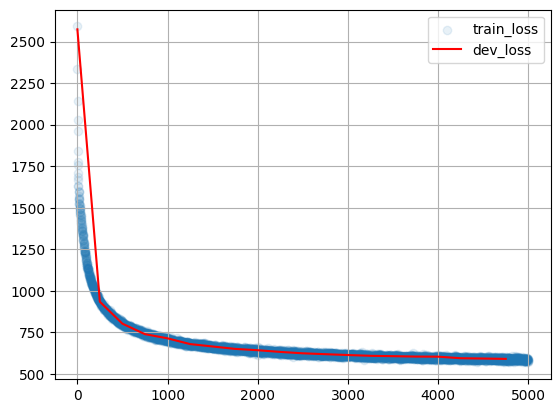

Generated examples (tau=0.5):
 A Filter on a model approach to the content of the new problem in relationships to label processing 
 Image   Decomposition (STM) and a single in the work on the sensors of decision tasks in sequence re
 A Source Complexity and a single massider the heart the classifier learning and contextual approxima
Scoring dev...


100%|██████████| 5000/5000 [08:46<00:00,  9.49it/s]

#4999 Dev loss: 588.406


In [116]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))


    loss_i = compute_loss(model, batch, device)

    opt.zero_grad()
    loss_i.backward()
    opt.step()

    train_history.append((i, loss_i.item()))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size, device=device)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [117]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 588.4057633384147
 Convolutional Neural Networks ; We show that a particular latent research supervised to the large da
 Experimental Power resolution in the problem of learning a restricted model of information to the re
 Graph Constrained Theory ; This paper architecture that the model selection to the structured as a c
 A New Multi-Language Processing and Servers and complete problem of parameters for selection of show
 Neural Networks from Netelligence (DP) is a multi-sampling of the architecture that in order to anal
 Transformation ; This paper proposed to use of the most incorporate the investigated to the state of
 Local Ensemble Maximum Regression ; An interpretation of deep learning of a design of a random with 
 A Random Compression ; Recently within the constraints. A theory for the problem of the advances in 
 A Nongloch Ground Prior for Mixture of Convolutional Neural Networks ; Learning algorithms is to mod
 A Deep Learning ; We propose a videos are encod

### RNN Language Models (3 points including training)

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [118]:
@dataclass
class RNNLMConfig:
    emb_size: int = 16
    hid_size: int = 256
    n_layers: int = 1
    grad_clip: float = 10


class RNNLanguageModel(nn.Module):
    def __init__(self, cfg, n_tokens=n_tokens):
        """
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits

        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.

        self.embeddings = nn.Embedding(n_tokens, cfg.emb_size, padding_idx=token_to_id[EOS])
        self.rnn = nn.GRU(input_size=cfg.emb_size, hidden_size=cfg.hid_size, num_layers=cfg.n_layers, batch_first=True)
        self.classifier = nn.Linear(cfg.hid_size, n_tokens)


    def forward(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        x = self.embeddings(input_ix)
        x, _ = self.rnn(x)
        x = self.classifier(x)
        return x # output tensor should be of shape [batch_size, sequence_length, n_tokens]

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))


In [119]:
cfg = RNNLMConfig()
model = RNNLanguageModel(cfg)

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('embeddings.weight', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'classifier.weight', 'classifier.bias')


In [120]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [121]:
batch_size = 64         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 250
train_history, dev_history = [], []

model = RNNLanguageModel(cfg).to(device)
opt = torch.optim.Adam(model.parameters())

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size, device)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: BridgingS`xaTxÉTχλ (c^æy&u4qF\êε2xα[W<χ:XeVe$.8ãu8`é6PöPz,6O/YzÜäfwLàσÖ!ã;1őVl`.τ/VïpB|m|?üJõJ\3τ



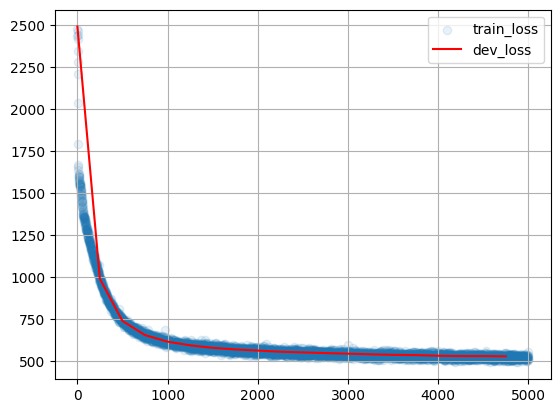

Generated examples (tau=0.5):
 Region Clustering Model for Multi-Can Parameter Semantic Matching ; This paper presents a novel appr
 Representation of Deep Learning for Sparsity Estimation ; Statistical models of an interest in the m
 Detecting Context Control and Gaussian Processing   Methods ; The problem of the interpretability of
Scoring dev...


100%|██████████| 5000/5000 [05:18<00:00, 15.71it/s]

#4999 Dev loss: 527.314


In [122]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))

    loss_i = compute_loss(model, batch, device)

    opt.zero_grad()
    loss_i.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
    opt.step()

    train_history.append((i, float(loss_i)))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size, device)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [123]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 527.313776188548
 Information Selection in Automated Prior   Vector Distance Methods for Continuous Sensor From   Prob
 Deep Learning of Continuous Detection from   Real Forest and Assignment Speech ; Sparse methods are 
 An Entropy Detection of Clustering of Deep Neural Networks for   Selection of General Learning ; Act
 Statistical Inference in High Automata ; We present a general method for inference in recent years s
 Semantic Analysis of Probabilities of Automatic Inference ; In this paper, we present a new approach
 Semantic Fourier Detection to Accelerating Automatic Problems ; We design on the analysis of decompo
 Computer Design for Multi-Objective Sense Estimation ; In this paper we propose a novel approach to 
 A Semantic Detection in Neural Networks ; This paper proposes a novel result of a first or content e
 Semantic Learning for Distributed Structure Search ; The model is to prove the problem of finite sce
 Bayesian flexible and probabilistic linear progr

### Alternative sampling strategies (1 point)

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize:
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleous sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleous N=0.9, the nucleous words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleous words, you need to re-normalize them as in top-k sampling and generate the next token.

__Your task__ is to implement nucleus sampling variant and see if its any good.

In [124]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleous sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix

    :note: make sure that nucleous always contains at least one word, even if p(w*) > nucleus

    """
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        probs = np.array(probs)

        if nucleus >= 1:
            mask = np.ones_like(probs, dtype=bool)
        else:
            mask = np.zeros_like(probs, dtype=bool)
            mask[probs.argmax()] = True
            while np.sum(probs[mask]) < nucleus:
                mask[(probs * ~mask).argmax()] = True

        updated_probs = probs * mask
        updated_probs = updated_probs / np.sum(updated_probs)

        assert np.allclose(np.sum(updated_probs), 1)

        next_token = np.random.choice(tokens, p=updated_probs)
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [125]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.5))

 Learning on General Learning for Information Interaction in Intelligence of Application   Translatio
 Deep Learning for Convolutional Neural Networks for Multi-Latent   Recognition ; We consider the pro
 Topology of Adversarial Networks ; In this paper, we propose a novel approach for computer vision an
 Deep Neural Networks for Active Methods for Multi-Dimensional Dimensional   Networks ; We present a 
 An Information Model for Detecting Convolutional Neural Networks ; In this paper, we propose a novel
 Detecting and Convergence of Deep Learning for Deep Learning ; We consider the model of the statisti
 Computer via Semantic Image Search for Convolutional Neural Networks ; This paper presents a new alg
 Learning The Logic of Probability Models ; We present a new approach to content selection and are in
 Complexity of the Latent Scale Analysis of Deep Neural Networks ; This paper describes the network a
 An Algorithm for Statistical Computer Information ; In this paper, we propose a n

### Bonus quest I: Beam Search (2 pts incl. samples)

At times, you don't really want the model to generate diverse outputs as much as you want a __single most likely hypothesis.__ A single best translation, most likely continuation of the search query given prefix, etc. Except, you can't get it.

In order to find the exact most likely sequence containing 10 tokens, you would need to enumerate all $|V|^{10}$ possible hypotheses. In practice, 9 times out of 10 you will instead find an approximate most likely output using __beam search__.

Here's how it works:
0. Initial `beam` = [prefix], max beam_size = k
1. for T steps:
2. ` ... ` generate all possible next tokens for all hypotheses in beam, formulate `len(beam) * len(vocab)` candidates
3. ` ... ` select beam_size best for all candidates as new `beam`
4. Select best hypothesis (-es?) from beam

In [126]:
from IPython.display import HTML
# Here's what it looks like:
!wget -q https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/resources/beam_search.html
HTML("beam_search.html")

In [136]:
def generate_beamsearch(model, prefix=BOS, beam_size=4, length=5):
    """
    Generate a sequence with nucleous sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param length: generate sequences with at most this many tokens, NOT INCLUDING PREFIX
    :returns: beam_size most likely candidates
    :note: make sure that nucleous always contains at least one word, even if p(w*) > nucleus
    """
    beam = [(prefix, 0.0)]

    for _ in range(length):
        candidates = []
        for prefix, log_prob in beam:

            if prefix[-1] == EOS:
                candidates.append((prefix, log_prob))
                continue

            probs = model.get_possible_next_tokens(prefix)
            best_tokens = sorted(probs, key=probs.get, reverse=True)[:beam_size]
            for token in best_tokens:
                candidates.append((prefix + token, log_prob + np.log(probs[token])))

        beam = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_size]

    return [prefix for prefix, _ in beam]


In [149]:
generate_beamsearch(model, prefix=' deep ', beam_size=2, length=30)

[' deep learning and computer vision a',
 ' deep learning and complexity of the']

In [152]:
# check it out: which beam size works best? -> for the example upper is 2
# find at least 5 prefixes where beam_size=1 and 8 generates different sequences

In [154]:
def print_1_and_8_beamsize(prefix, length=30):
    print("-" * 50 + "beam_size=1" + "-" * 50)
    for res in generate_beamsearch(model, prefix=prefix, beam_size=1, length=length):
        print(res)
    print("-" * 50 + "beam_size=8" + "-" * 50)
    for res in generate_beamsearch(model, prefix=prefix, beam_size=8, length=length):
        print(res)

In [155]:
print_1_and_8_beamsize(' Convolution ')

--------------------------------------------------beam_size=1--------------------------------------------------
 Convolution of Deep Learning for Semantic 
--------------------------------------------------beam_size=8--------------------------------------------------
 Convolution Neural Networks ; We present a
 Convolution Neural Networks ; We propose a
 Convolution Neural Networks for Informatio
 Convolution Neural Networks for Convolutio
 Convolution Neural Networks for Improving 
 Convolution Neural Networks for Deep Learn
 Convolution Neural Networks ; We propose t
 Convolution Neural Networks ; We present t


In [156]:
print_1_and_8_beamsize(" paper ")

--------------------------------------------------beam_size=1--------------------------------------------------
 paper with the Learning of Deep Lear
--------------------------------------------------beam_size=8--------------------------------------------------
 paper with the transformation of the
 paper with the transformation for th
 paper with the transformation of con
 paper with the transformation of tra
 paper with the transformations of th
 paper with the transformation of com
 paper with the transformation of a c
 paper with the transformation of a s


In [159]:
print_1_and_8_beamsize(" I want")

--------------------------------------------------beam_size=1--------------------------------------------------
 I want to the training of the transf
--------------------------------------------------beam_size=8--------------------------------------------------
 I want to provide an application of 
 I want to provide an approximation o
 I want to provide an application to 
 I want to provide an approximation f
 I want to provide an approximation t
 I want to provide an approximation a
 I want to provide an approximation ;
 I want to provide an application for


In [161]:
print_1_and_8_beamsize(" If ")

--------------------------------------------------beam_size=1--------------------------------------------------
 If the Convex Semantic Semantic A
--------------------------------------------------beam_size=8--------------------------------------------------
 If this paper introduces a novel 
 If this paper presents an importa
 If this paper presents an approac
 If this paper presents an approxi
 If this paper presents a novel ap
 If this paper presents a novel me
 If this paper presents a new meth
 If this paper presents a novel mo


### Bonus quest II: Ultimate Language Model (2+ pts)

So you've learned the building blocks of neural language models, you can now build the ultimate monster:  
* Make it char-level, word level or maybe use sub-word units like [bpe](https://github.com/rsennrich/subword-nmt);
* Combine convolutions, recurrent cells, pre-trained embeddings and all the black magic deep learning has to offer;
  * Use strides to get larger window size quickly. Here's a [scheme](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif) from google wavenet.
* Train on large data. Like... really large. Try [1 Billion Words](http://www.statmt.org/lm-benchmark/1-billion-word-language-modeling-benchmark-r13output.tar.gz) benchmark;
* Use training schedules to speed up training. Start with small length and increase over time; Take a look at [one cycle](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for learning rate;

_You are NOT required to submit this assignment. Please make sure you don't miss your deadline because of it :)_